<p style="text-align: center"> <b> Tensorflow-2. How to build (and deal with) datasets </b> </p>

#### Option 1 - read on fly

In [1]:
from pathlib import Path

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [2]:
HEIGHT = 370
WIDTH = 278

In [3]:
def extract_name(file: Path):
    name = file.stem.split("_")[0]
    return name

In [4]:
def encode_single_sample(img_path, encoded_label):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [HEIGHT, WIDTH])
    return img, encoded_label

In [5]:
def get_dataset(ds_path: Path, batch_size: int):
    paths = [path for path in ds_path.glob("*.jpg")]
    images = [str(file) for file in paths]
    labels = [extract_name(file) for file in paths]
    assert len(images) == len(labels)
    images = np.array(images)
    labels = np.array(labels)

    ds = tf.data.Dataset.from_tensor_slices((images, labels))

    ds = ds.map(encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE). \
        batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return ds

In [6]:
ds_path = Path("./data")

In [7]:
ds = get_dataset(ds_path, batch_size=3)

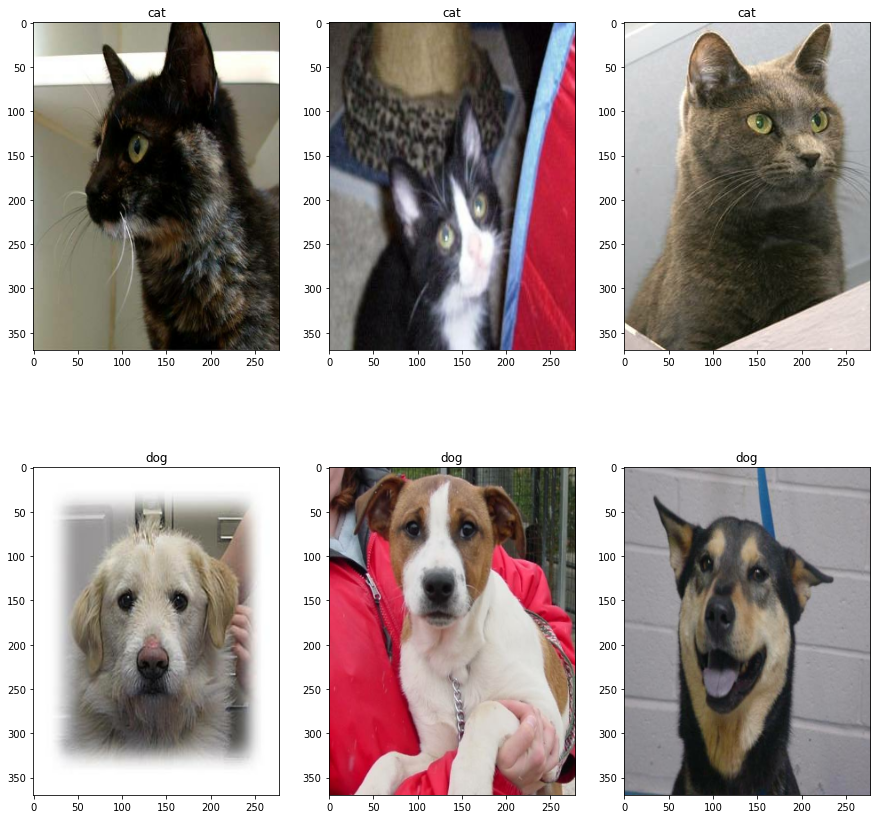

In [8]:
rows, cols = 2, 3
fig, axs = plt.subplots(rows, cols, figsize=(15,15))
for i, (images, names) in enumerate(ds):
    for j, (image, name) in enumerate(zip(images, names)):
        image = image.numpy()
        name = name.numpy().decode("utf-8")
        axs[i,j].imshow(image)
        axs[i,j].set_title(name)
plt.show()

#### Option 2 -  records

* Write records

In [9]:
import contextlib

import cv2
from tqdm import tqdm

from dataset_utils import dataset_util
from dataset_utils import tf_record_creation_util

In [10]:
feature_description = {
    'image': tf.io.FixedLenFeature([], tf.string),
    'name': tf.io.FixedLenFeature([], tf.string, default_value='')
}

In [11]:
def create_tf_example(img_path: Path, width: int, height: int):
    if not img_path.exists():
        return None
    try:
        img = cv2.imread(str(img_path))
    except AttributeError:
        return None
    img = cv2.resize(img, (width, height))
    img = cv2.imencode(img_path.suffix, img)[1].tostring()
    try:
        name = extract_name(img_path)
    except (ValueError, KeyError) as ex:
        print(ex)
        print(img_path)
        return None
    # create example
    tf_example = tf.train.Example(features=tf.train.Features(feature={
        'image': dataset_util.bytes_feature(img),
        'name': dataset_util.bytes_feature(name.encode("utf-8"))
    }))
    return tf_example

In [12]:
def create_records(output_filebase: Path, files: list, num_shards: int, width: int, height: int) -> None:
    with contextlib.ExitStack() as tf_record_close_stack:
        output_tfrecords = tf_record_creation_util.open_sharded_output_tfrecords(
            tf_record_close_stack, output_filebase, num_shards)
        index = 0
        for img in tqdm(files, total=len(files), ncols=60):
            tf_example = create_tf_example(img, width, height)
            if tf_example:
                output_shard_index = index % num_shards
                output_tfrecords[output_shard_index].write(tf_example.SerializeToString())
                index += 1

In [13]:
def write_records(img_path: Path, out_path: Path, num_shards: int = 2):
    files = [img for img in img_path.glob("*.jpg")]
    output_filebase = out_path / "test_dataset.record"
    create_records(output_filebase, files, num_shards, width=278, height=370)

In [14]:
def _parse_function(example_proto):
    example = tf.io.parse_single_example(example_proto, feature_description)
    image = tf.cast(tf.io.decode_jpeg(example['image'], channels=3), tf.float32)
    image = tf.divide(image, 255)
    name = example['name']
    return image, name

In [15]:
def get_dataset(records: list, batch_size: int = 2):
    ds = tf.data.TFRecordDataset(records)
    ds = ds.map(_parse_function).batch(batch_size)
    return ds

In [16]:
img_path = Path("./data")
out_path = Path("./records")

In [17]:
write_records(img_path, out_path, num_shards=2)

100%|████████████████████████| 6/6 [00:00<00:00, 110.87it/s]


Output files count equals num_shards (useful for large datasets)

In [18]:
rec_path = Path("./records")
records = [str(file) for file in rec_path.glob("*")]
records

['records/test_dataset.record-00000-of-00002',
 'records/test_dataset.record-00001-of-00002']

* Read records

In [19]:
ds = get_dataset(records, batch_size=3)

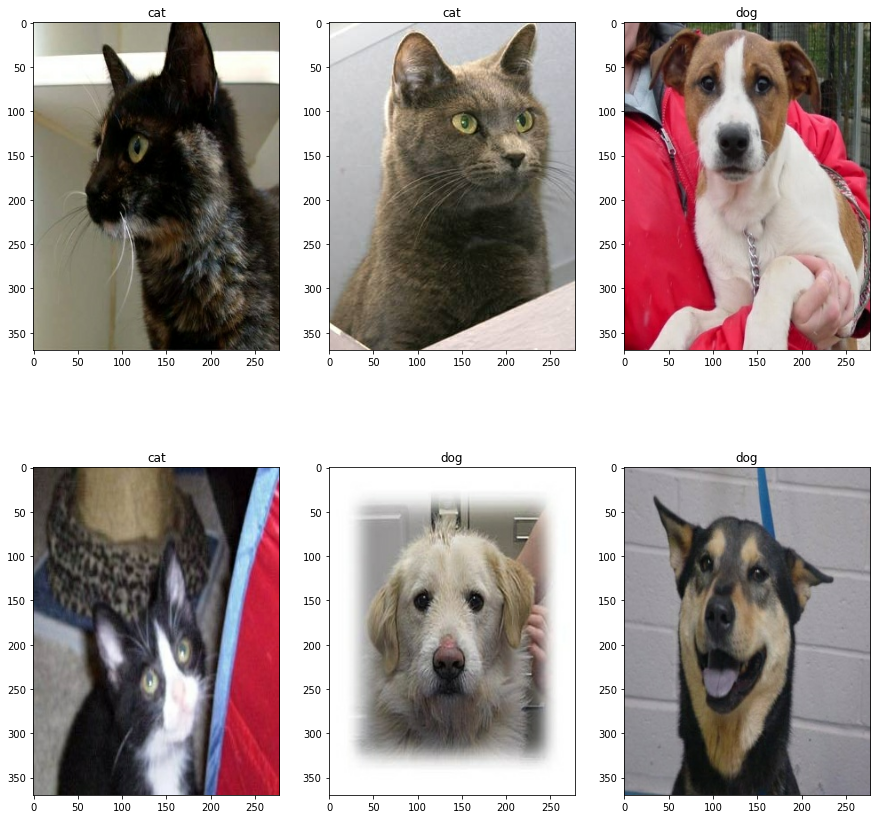

In [20]:
# batch size=3 for good looking plot 
rows, cols = 2, 3
fig, axs = plt.subplots(rows, cols, figsize=(15,15))
for i, (images, names) in enumerate(ds):
    for j, (image, name) in enumerate(zip(images, names)):
        image = image.numpy()
        name = name.numpy().decode("utf-8")
        axs[i,j].imshow(image)
        axs[i,j].set_title(name)
plt.show()

<p style="text-align: center"> <b> Augmentations with imgaug </b> </p>

In [21]:
# Example from: https://github.com/aleju/imgaug

In [22]:
from augmentation_model import seq

In [23]:
# Override parse function (not divide by 255)

def _parse_function(example_proto):
    example = tf.io.parse_single_example(example_proto, feature_description)
    image = tf.cast(tf.io.decode_jpeg(example['image'], channels=3), tf.float32)
    name = example['name']
    return image, name

In [24]:
def normalize_image(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.divide(image, 255)
    return image, label

In [25]:
def tf_random_augmentations(image, label):
    def augment_image(image):
        return seq(images=[image.numpy()])

    [image, ] = tf.py_function(augment_image, [image], [tf.uint8])
    return image, label

In [26]:
ds = tf.data.TFRecordDataset(records)

In [27]:
# making chain - map(parse)->map(tf_random_augmentations)->map(normalize)
ds = ds.map(_parse_function).map(tf_random_augmentations).map(normalize_image).batch(3)

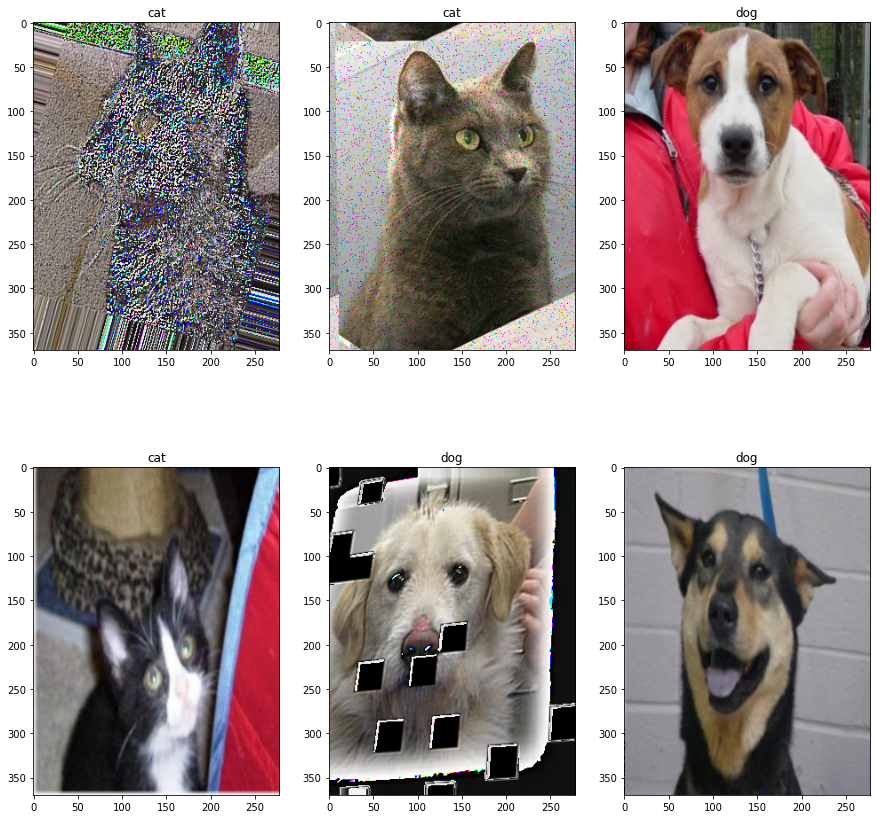

In [28]:
rows, cols = 2, 3
fig, axs = plt.subplots(rows, cols, figsize=(15,15))
for i, (images, names) in enumerate(ds):
    for j, (image, name) in enumerate(zip(images, names)):
        image = image.numpy()
        name = name.numpy().decode("utf-8")
        axs[i,j].imshow(image)
        axs[i,j].set_title(name)
plt.show()